In [1]:
%%bash
echo $CMSSW_BASE
echo $PWD

/afs/cern.ch/work/i/innocent/public/code/s7/CMSSW_9_3_0_pre2
/afs/cern.ch/user/i/innocent/POS2017/exercise2_TkHistos


In [2]:
%%bash
uname -a
whoami

edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root
edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root

Linux vinavx3.cern.ch 3.10.0-514.10.2.el7.x86_64 #1 SMP Fri Mar 3 00:04:05 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root (1 runs, 1 lumis, 1522 events, 2449095209 bytes)
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root (1 runs, 3 lumis, 4077 events, 2088712010 bytes)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
from DataFormats.FWLite import Handle, Events

Welcome to JupyROOT 6.10/01


In [6]:
#LS50
events2016HL = Events("root://cms-xrd-global.cern.ch///store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/AE49FDAB-8398-E611-9B98-02163E014388.root")
#LS1000
events2016LL = Events("root://cms-xrd-global.cern.ch///store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/88FB6BA5-7B98-E611-B25E-FA163EE1CC08.root")

events2017B_HL = Events("root://cms-xrd-global.cern.ch///store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/061/00000/5C4984B0-B86A-E711-837F-02163E01A792.root")
events2017B_LL = Events("root://cms-xrd-global.cern.ch///store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/067/00000/B4146406-F66A-E711-B9C9-02163E014389.root")

tracks = Handle("std::vector<reco::Track>")
label = "generalTracks"
quality = "highPurity"

In [7]:
def nt(events) :
    nt = []
    for i in range(0,1000) : # events.size()):
      a= events.to(i)
      if (i%500==0) : print "Event", i 
      a=events.getByLabel(label, tracks)
      nt.append(tracks.product().size())
    print len(nt)
    return nt

Event 0
Event 500
1000


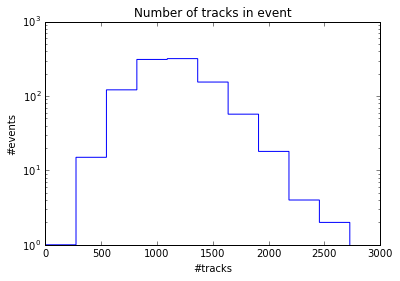

In [8]:
nt = nt(events2017B_HL)
fig, ax = plt.subplots()
ax.hist(nt,histtype='step', fill=False)
ax.set_title('Number of tracks in event')
ax.set_xlabel('#tracks')
ax.set_ylabel('#events')
plt.yscale('log', nonposy='clip')
plt.show()

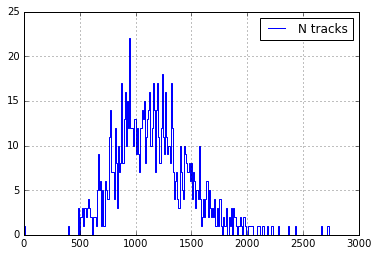

In [9]:
y,x = np.histogram(nt,np.linspace(0.,3000.,300))
x.resize(len(y))
plt.step(x,y,where='post',label='N tracks')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [10]:
def loadTk(events) :
    print events
    tkParsA = []
    tkHitsA = []
    for i in range(0,2000) : # events.size())
      if (len(tkParsA) > 1000000) : break
      a= events.to(i)
      if (i%500==0) : 
        id = events.object().id()
        evid = '{:d}:{:d}:{:d}'.format(int(id.run()),int(id.luminosityBlock()), int(id.event()))
        print "Event", i , evid
      a=events.getByLabel(label, tracks)
      for tk in tracks.product() :
        if (not tk.quality(tk.qualityByName(quality))) : continue
        pattern = tk.hitPattern()
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(), tk.ndof(),tk.chi2(),tk.originalAlgo()-4])
        tkHitsA.append([pattern.numberOfValidHits(),pattern.numberOfValidPixelHits()])

    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA), dtype=np.float)
    print len(tkPars)
    tkHits = np.array(zip(*tkHitsA), dtype=np.int)
    print len(tkHits)
    return (tkPars,tkHits)

In [30]:
def loadFile() :
    loaded = np.load('/tmp/events2017B_LL.npz')
    return loaded['tkPars'], loaded['tkHits']

In [31]:
fromAOD = False
tkPars, tkHits = loadTk(events2017B_LL) if fromAOD else loadFile()

In [32]:
if fromAOD :
    np.savez_compressed('/tmp/events2017B_LL',tkPars=tkPars, tkHits=tkHits)

In [33]:
%%bash
ls -l /tmp/events2017B_LL*

-rw-r--r--. 1 innocent zh 29809997 Jul 29 17:46 /tmp/events2017B_LL.npz


In [34]:
def nhit(var,tkPars, tkHits) :
    hp = np.greater(tkPars[2],1.)
    nbins=62
    yn,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=tkHits[0]*hp)
    ya,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp)
    x.resize(len(ya))
    return x,yn/ya
    

70.6597290039 22 4

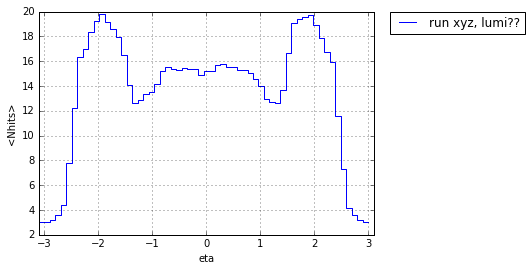

In [35]:
print tkPars[4][0],tkHits[0][0],tkHits[1][0],
eta=0
phi=1
pt=2

var = eta
x,y = nhit(eta,tkPars, tkHits)

plt.step(x,y,where='post',label='run xyz, lumi??')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-3.1, 3.1)
plt.xlabel('eta')
plt.ylabel('<Nhits>')
plt.show()